<a href="https://colab.research.google.com/github/JeongCheolHee/paper/blob/main/GAN_%EC%BD%94%EB%93%9C%EA%B5%AC%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GAN 코드 구현



*   논문 : Generative adversarial Networks
    <a href="https://file.notion.so/f/s/8f242fd2-55d3-4006-9deb-f89b4f727540/Generative_Adversarial_Nets.pdf?id=6a860c82-7b62-4cd9-88f3-9a0d5759e04f&table=block&spaceId=727d1048-4d91-4d4d-8af2-a994df2b49e2&expirationTimestamp=1692057600000&signature=Ym2VVlbJ_CB4ldF5_wJtL82tTyqtNPU85uAajEe-hLI&downloadName=Generative+Adversarial+Nets.pdf">PDF 파일 보기</a>
*   학습 데이터 : MNIST






## 필요한 라이브러리 불러오기

In [1]:
# 파이토치 사용
import torch
import torch.nn as nn # 생성자와 판별자의 아키텍쳐 정의

from torchvision import datasets # MNIST 불러오기
import torchvision.transforms as transforms #전처리 과정
from torchvision.utils import save_image # 학습 과정 이미지 출력

##생성자(Generator) 및 판별자(Discriminator) 모델 정의

In [2]:
latent_dim = 100


# 생성자(Generator) 클래스 정의
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # 하나의 블록(block) 정의
        def block(input_dim, output_dim, normalize=True):
            layers = [nn.Linear(input_dim, output_dim)]
            if normalize:
                # 배치 정규화(batch normalization) 수행(차원 동일)
                layers.append(nn.BatchNorm1d(output_dim, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        # 생성자 모델은 연속적인 여러 개의 블록을 가짐
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 1 * 28 * 28),
            nn.Tanh()
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.size(0), 1, 28, 28)
        return img

In [3]:
# 판별자(Discriminator) 클래스 정의
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(1 * 28 * 28, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    # 이미지에 대한 판별 결과를 반환
    def forward(self, img):
        flattened = img.view(img.size(0), -1)
        output = self.model(flattened)

        return output

## 학습 데이터셋 불러오기

In [4]:
transforms_train = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

train_dataset = datasets.MNIST(root="./dataset", train=True, download=True, transform=transforms_train)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)

100%|██████████| 9912422/9912422 [00:00<00:00, 372252018.98it/s]

Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 112475110.33it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 192573480.26it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 21050308.03it/s]


Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


##모델 학습 및 샘플링

*   학습을 위해 생성자와 판별자 모델 초기화
*   적절한 하이퍼파라미터 설정



In [5]:
# 생성자(generator)와 판별자(discriminator) 초기화
generator = Generator()
discriminator = Discriminator()

generator.cuda()
discriminator.cuda()

# 손실 함수(loss function)
adversarial_loss = nn.BCELoss()
adversarial_loss.cuda()

# 학습률(learning rate) 설정
lr = 0.0002

# 생성자와 판별자를 위한 최적화 함수
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))

In [6]:
import time

n_epochs = 200 # 학습의 횟수(epoch) 설정
sample_interval = 2000 # 몇 번의 배치(batch)마다 결과를 출력할 것인지 설정
start_time = time.time()

for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(dataloader):

        # 진짜(real) 이미지와 가짜(fake) 이미지에 대한 정답 레이블 생성
        real = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(1.0) # 진짜(real): 1
        fake = torch.cuda.FloatTensor(imgs.size(0), 1).fill_(0.0) # 가짜(fake): 0

        real_imgs = imgs.cuda()

        """ 생성자(generator)를 학습합니다. """
        optimizer_G.zero_grad()

        # 랜덤 노이즈(noise) 샘플링
        z = torch.normal(mean=0, std=1, size=(imgs.shape[0], latent_dim)).cuda()

        # 이미지 생성
        generated_imgs = generator(z)

        # 생성자(generator)의 손실(loss) 값 계산
        g_loss = adversarial_loss(discriminator(generated_imgs), real)

        # 생성자(generator) 업데이트
        g_loss.backward()
        optimizer_G.step()

        """ 판별자(discriminator)를 학습합니다. """
        optimizer_D.zero_grad()

        # 판별자(discriminator)의 손실(loss) 값 계산
        real_loss = adversarial_loss(discriminator(real_imgs), real)
        fake_loss = adversarial_loss(discriminator(generated_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2

        # 판별자(discriminator) 업데이트
        d_loss.backward()
        optimizer_D.step()

        done = epoch * len(dataloader) + i
        if done % sample_interval == 0:
            # 생성된 이미지 중에서 25개만 선택하여 5 X 5 격자 이미지에 출력
            save_image(generated_imgs.data[:25], f"{done}.png", nrow=5, normalize=True)

    # 하나의 epoch이 끝날 때마다 로그(log) 출력
    print(f"[Epoch {epoch}/{n_epochs}] [D loss: {d_loss.item():.6f}] [G loss: {g_loss.item():.6f}] [Elapsed time: {time.time() - start_time:.2f}s]")

[Epoch 0/200] [D loss: 0.637676] [G loss: 1.543643] [Elapsed time: 21.91s]
[Epoch 1/200] [D loss: 0.543998] [G loss: 0.543446] [Elapsed time: 36.62s]
[Epoch 2/200] [D loss: 0.466527] [G loss: 2.233311] [Elapsed time: 51.45s]
[Epoch 3/200] [D loss: 0.382086] [G loss: 1.577314] [Elapsed time: 66.34s]
[Epoch 4/200] [D loss: 0.262612] [G loss: 1.498208] [Elapsed time: 81.30s]
[Epoch 5/200] [D loss: 0.370482] [G loss: 2.185177] [Elapsed time: 97.21s]
[Epoch 6/200] [D loss: 0.421748] [G loss: 0.659997] [Elapsed time: 112.54s]
[Epoch 7/200] [D loss: 0.252425] [G loss: 1.623384] [Elapsed time: 127.47s]
[Epoch 8/200] [D loss: 0.308261] [G loss: 1.172842] [Elapsed time: 142.47s]
[Epoch 9/200] [D loss: 0.661965] [G loss: 5.262400] [Elapsed time: 157.19s]
[Epoch 10/200] [D loss: 0.734141] [G loss: 4.110980] [Elapsed time: 172.54s]
[Epoch 11/200] [D loss: 0.206946] [G loss: 2.736182] [Elapsed time: 187.95s]
[Epoch 12/200] [D loss: 0.386274] [G loss: 3.956741] [Elapsed time: 202.70s]
[Epoch 13/200] 



*   생성된 이미지 예시


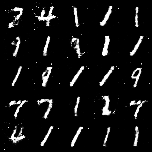

In [7]:
from IPython.display import Image

Image('92000.png')